# This notebook is the sample code to show how to control the style of AI Art 

# Generated Image using ControlNet.

ControlNet was introduced in [Adding Conditional Control to Text-to-Image Diffusion Models by Lvmin Zhang and Maneesh Agrawala](https://arxiv.org/abs/2302.05543). It introduces a framework that allows for supporting various spatial contexts that can serve as additional conditionings to Diffusion models such as Stable Diffusion.

Let's prepare the required libraries

In [ ]:
!pip install -q diffusers==0.14.0 transformers xformers git+https://github.com/huggingface/accelerate.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 737.4/737.4 KB 39.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 63.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 MB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.8/199.8 KB 25.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 111.3 MB/s eta 0:00:00


In [ ]:
!pip install -q opencv-contrib-python
!pip install -q controlnet_aux

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 KB 5.4 MB/s eta 0:00:00


In [ ]:
import cv2
from PIL import Image
import numpy as np


In [ ]:
def image_grid(imgs, rows, cols):
    assert len(imgs) == rows * cols

    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

In [ ]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

Error caught was: No module named 'triton'


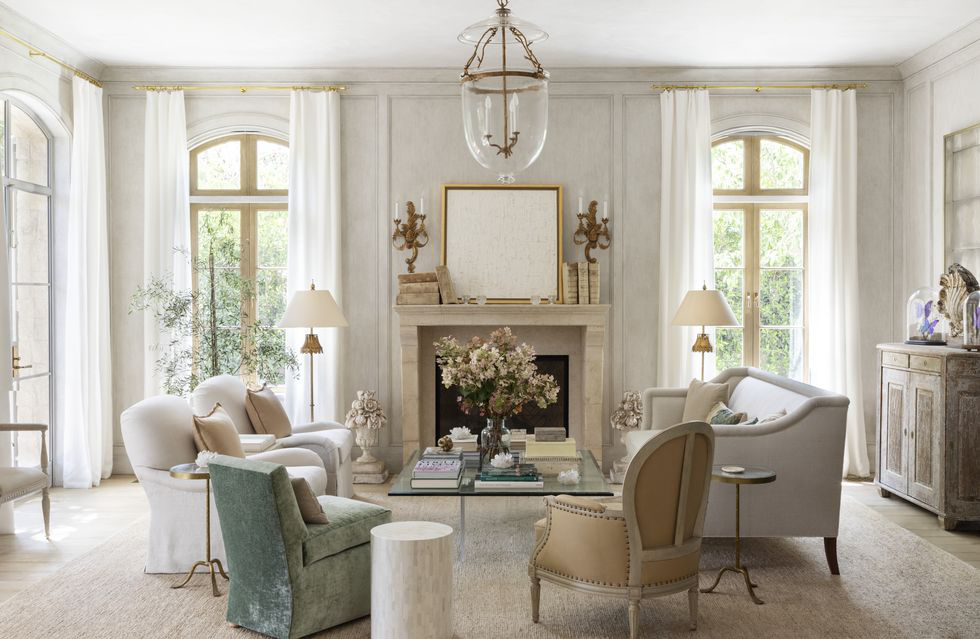

In [ ]:
from diffusers import StableDiffusionControlNetPipeline
from diffusers.utils import load_image

image = load_image(  
    "https://beautiful-day.s3.amazonaws.com/livingroom3.jpg"
)
image

Lets put the image through the canny pre-processor which is essentially edge detection.

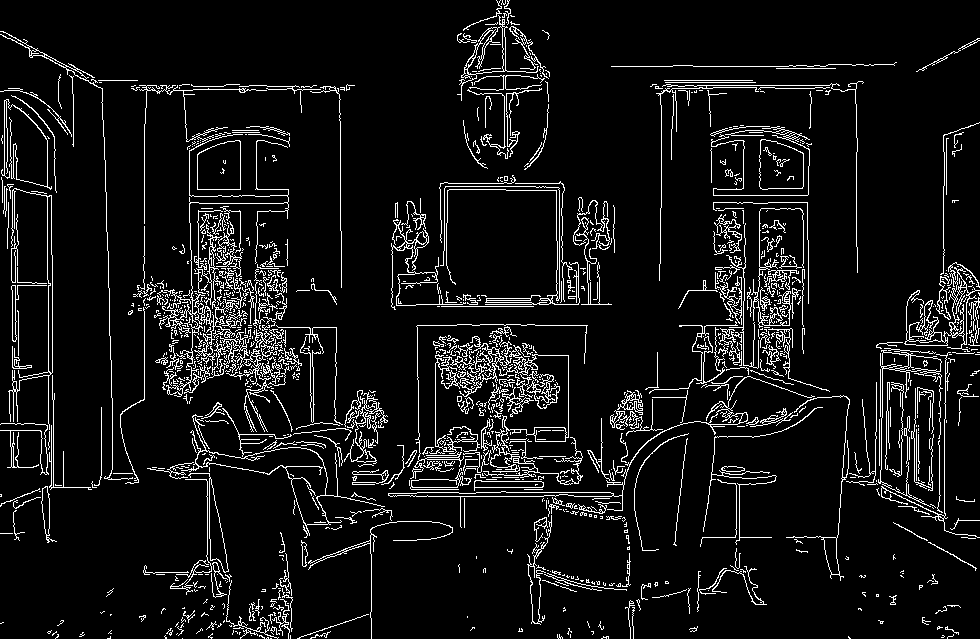

In [ ]:
import cv2
from PIL import Image
import numpy as np

image = np.array(image)

low_threshold = 100
high_threshold = 200

image = cv2.Canny(image,low_threshold, high_threshold)
image = image[:, :, None]
image = np.concatenate([image, image, image], axis=2)
canny_image = Image.fromarray(image)
canny_image

Now we load runwaylml/stable-diffusion-v1-5 as well as the ControlNet model for canny edges. The models are loaded in half-precision (torch.dtype) to allow for fast and memory-efficient inference.

In [ ]:
from diffusers import StableDiffusionControlNetPipeline, ControlNetModel
import torch

controlnet = ControlNetModel.from_pretrained("lllyasviel/sd-controlnet-canny", torch_dtype=torch.float16)
pipe = StableDiffusionControlNetPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5", controlnet=controlnet, torch_dtype=torch.float16
)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
/usr/local/lib/python3.9/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


In [ ]:
from diffusers import UniPCMultistepScheduler

pipe.scheduler = UniPCMultistepScheduler.from_config(pipe.scheduler.config)

In [ ]:
pipe.enable_model_cpu_offload()

In [ ]:
pipe.enable_xformers_memory_efficient_attention()

  0%|          | 0/50 [00:00<?, ?it/s]

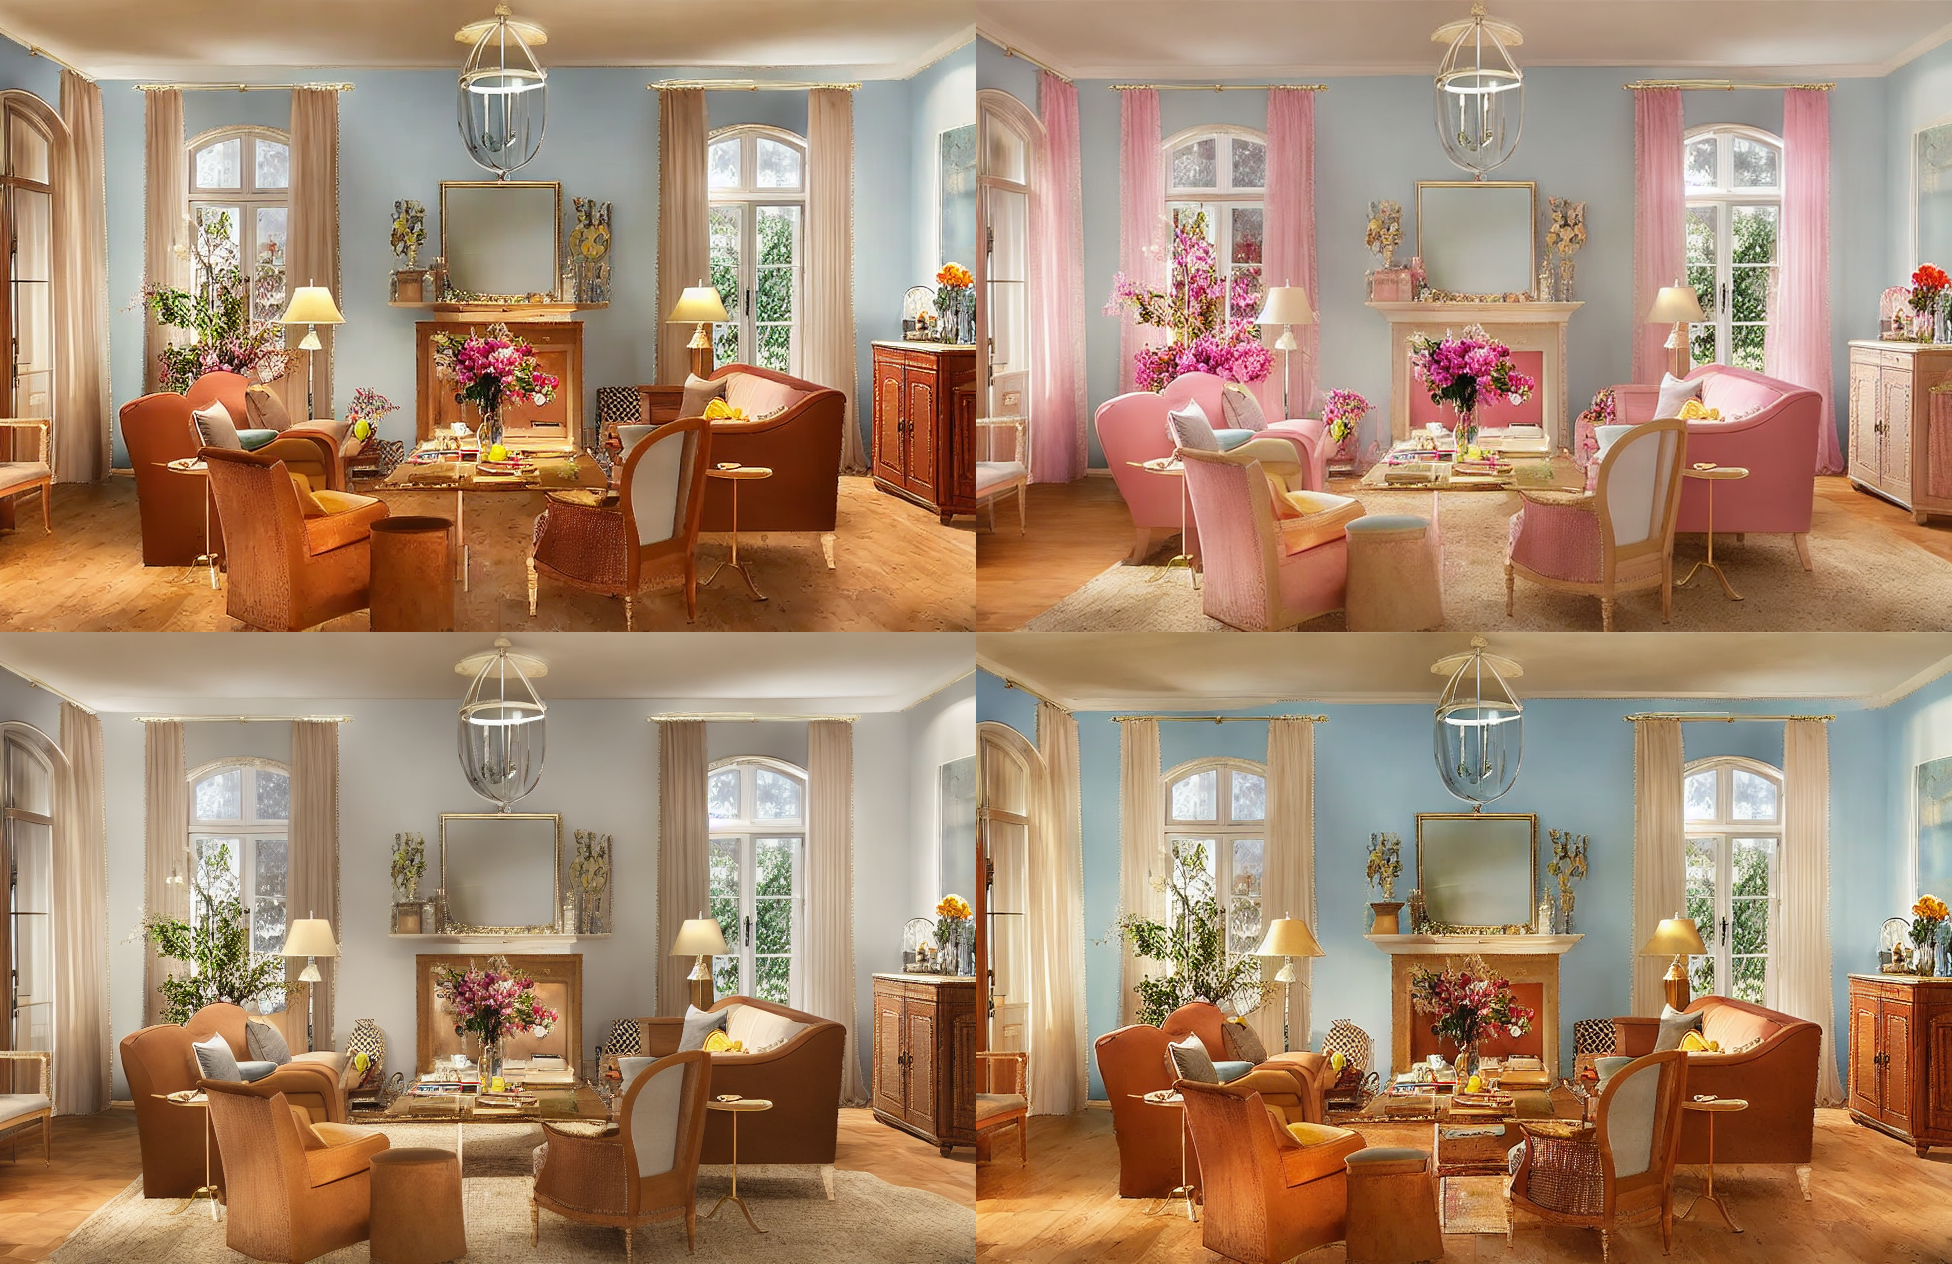

In [ ]:
prompt = "  ,best quality, extremely detailed"
prompt = [t + prompt for t in ["beautiful room, modern kitchen", "adorable room, beautiful flowers", "modern living room", "amazing living room, sun ray"]]
generator = [torch.Generator(device="cpu").manual_seed(2) for i in range(len(prompt))]

output = pipe(
    prompt,
    canny_image,
    negative_prompt=["monochrome, lowres, bad anatomy, worst quality, low quality"] * len(prompt),
    generator=generator,
    num_inference_steps=50,
)

image_grid(output.images, 2, 2)